# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd


strategyArray = []
gainArray     = []
lossArray     = []

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
aux = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    aux.append(myList)

aux = pd.DataFrame(aux)
scaler = MinMaxScaler()

def loadDataset(): 
    scaler.fit(aux.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(aux.values) 
    
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return abs(invertNorm(value1) - invertNorm(value2))

features, result = loadDataset()

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += (getError(predicted[0], expected[0]) 
            + getError(predicted[2], expected[2]) 
            + getError(predicted[4], expected[4]) 
            + getError(predicted[6], expected[6])) / 4
            
            lossError += (getError(predicted[1], expected[1])
            + getError(predicted[3], expected[3]) 
            + getError(predicted[5], expected[5]) 
            + getError(predicted[7], expected[7])) / 4
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):   
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = gainArray

    axis.boxplot(data)
    axis.set_title("Gain error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [6]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data       = lossArray

    axis.boxplot(data)
    axis.set_title("Loss error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1), fontsize = 14)
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotDistribution(regressor):
    features, result = loadDataset()
    regressor.fit(features, result)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))

    axis.scatter(result[:, 0], result[:, 1])
    axis.scatter(predicted[:, 0], predicted[:, 1], c = "m")

    axis.set_title(strategyArray[-1])
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

# Putting all together

In [8]:
gainArray = []
lossArray = []

[3.59293426 3.08144225 3.65407553 3.39272143 2.99613113] => 3.34 (+/- 0.53)
[3.43369059 3.22546874 3.16573909 3.62264857 3.67776901] => 3.43 (+/- 0.41)


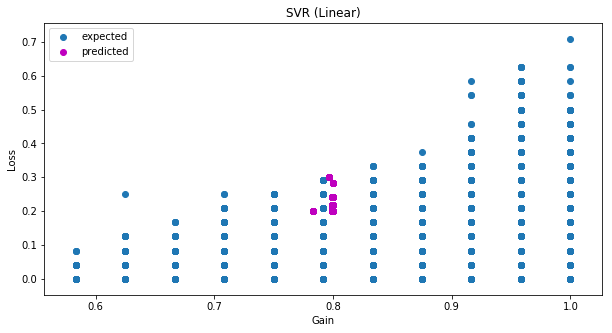

In [9]:
linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
trainModel(linearSVR)
strategyArray.append("SVR (Linear)")
plotDistribution(linearSVR)

[20.6093281  11.69364891 17.4025689  11.73457383 14.5452457 ] => 15.20 (+/- 6.86)
[2.05491308 1.94533172 2.44489122 2.14295189 1.83637276] => 2.08 (+/- 0.41)


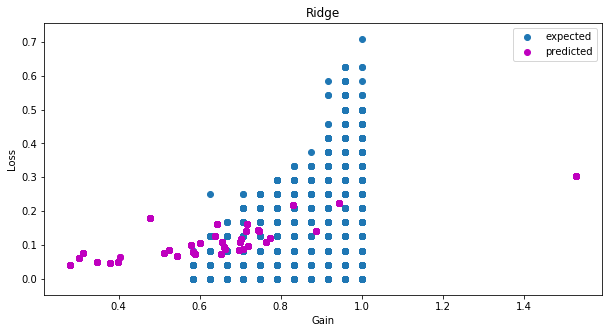

In [10]:
ridge = MultiOutputRegressor(KernelRidge(alpha = 1.0))
trainModel(ridge)
strategyArray.append("Ridge")
plotDistribution(ridge)

[2.1341397  1.76198338 2.12317876 1.95474162 2.00499336] => 2.00 (+/- 0.27)
[2.17502457 1.9903105  2.16155044 2.24139334 1.92055817] => 2.10 (+/- 0.24)


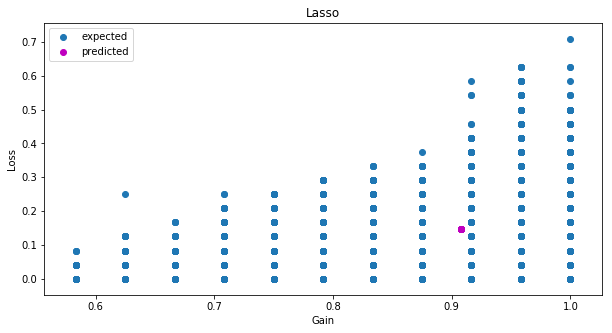

In [11]:
lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
trainModel(lasso)
strategyArray.append("Lasso")
plotDistribution(lasso)

[2.1842755  1.76488505 2.05707374 1.97245406 2.0055925 ] => 2.00 (+/- 0.27)
[2.1431484  1.96989534 2.14568218 2.15362086 1.90599084] => 2.06 (+/- 0.21)


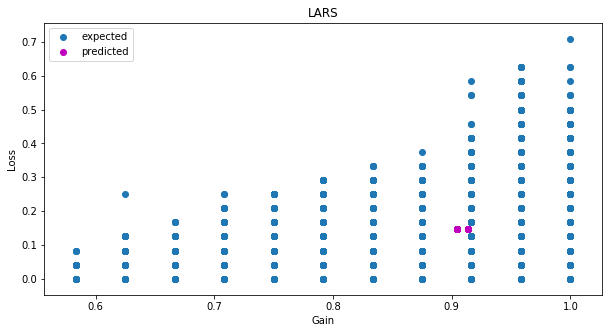

In [12]:
lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
trainModel(lars)
strategyArray.append("LARS")
plotDistribution(lars)

[2.56607092 2.08717602 2.06224958 1.73478639 2.50237086] => 2.19 (+/- 0.62)
[2.38837167 2.13126384 2.29436388 2.49925678 2.37694829] => 2.34 (+/- 0.24)


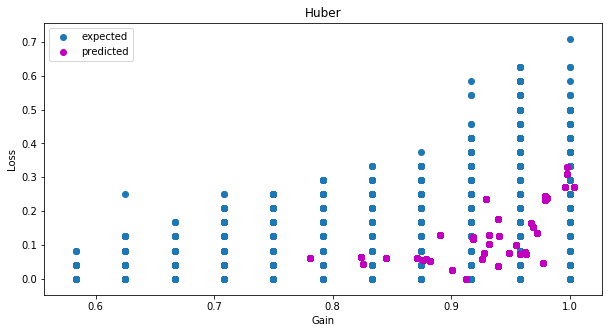

In [13]:
huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
trainModel(huber)
strategyArray.append("Huber")
plotDistribution(huber)

[2.16517094 1.71139601 1.79786325 1.86588319 2.24059829] => 1.96 (+/- 0.42)
[2.06595442 2.1514245  2.38376068 3.11346154 2.82150997] => 2.51 (+/- 0.80)


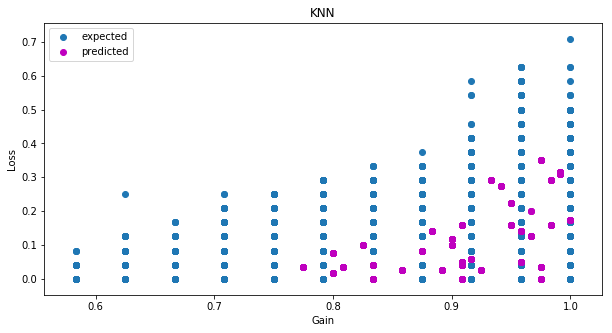

In [14]:
knn = MultiOutputRegressor(KNeighborsRegressor())
trainModel(knn)
strategyArray.append("KNN")
plotDistribution(knn)

[2.54831411 1.8272128  2.02116709 1.7146279  2.1134125 ] => 2.04 (+/- 0.58)
[1.9710604  1.9088993  2.2298655  2.48793856 2.70574622] => 2.26 (+/- 0.61)


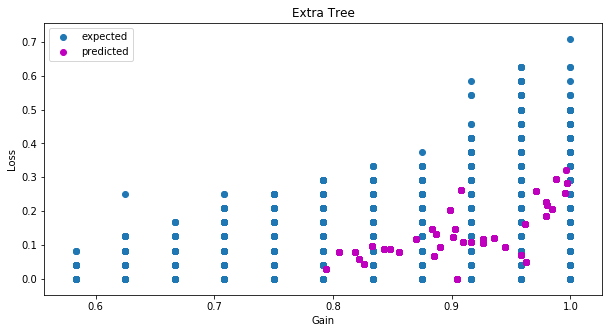

In [15]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
trainModel(bret)
strategyArray.append("Extra Tree")
plotDistribution(bret)

# Plotting error boxplots

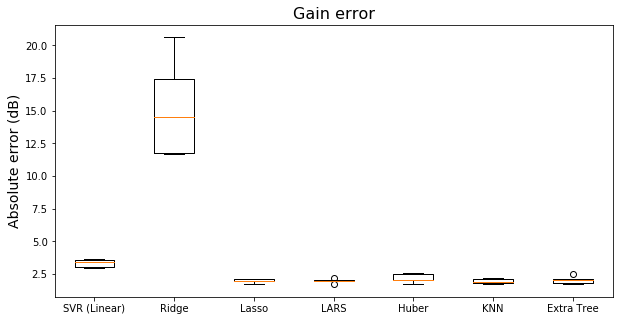

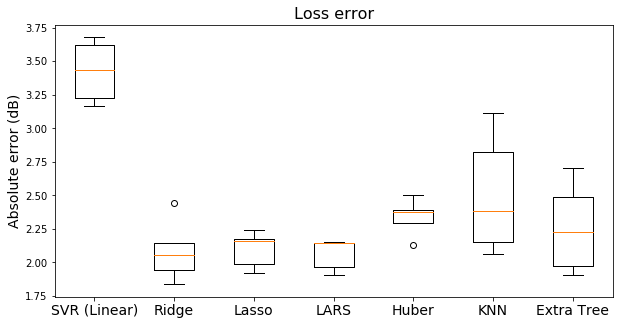

In [16]:
plotGainError()
plotLossError()